# Sektion 5 - Collision-free Multi-Vehicle Routing

## Functions 

In [1]:
def get_unique_nodes(edge_list):
    """
    Creates a list of all unique nodes appearing in a given graph.
    The start node is added by default; every other node is only included
    if it can be reached from another node. Isolated nodes will not be 
    added to the list, unless they happen to be the start node.
    """
    
    nr_nodes = 0
    unique_nodes = []
    unique_nodes.append(start_node)

    for edge in edge_list:
        if edge[1] not in unique_nodes:
            unique_nodes.append(edge[1])

    return unique_nodes


In [2]:
def construct_sliced_graph(edge_list, dest):
    """
    Constructs a two-dimensional array from a list of edges. Each subarray represents 
    one time slice. The returned array contains the specified start node in the 
    first sub-array; based on this start node, every node that can be reached in 
    n steps is present in the nth subarray. Nodes that can be reached in a different 
    amount of steps are present in every fitting subarray.
    """

    sg = [] # sliced graph
    sg.append([start_node])
    node_counter = 1


    nr_unique_nodes = len(get_unique_nodes(edge_list))

    for k in range(nr_unique_nodes):
    
        if len(sg[k]) != 0 and not (len(sg[k]) == 1 and sg[k][0] == dest):
            sg.append([])
            for j in range(len(edge_list)):
                # for a given edge j in the format a->b:
                # if a is in previous slice and b is not in this slice, and if b is not the start node, add it to the slice
                if edge_list[j][0] in sg[k] and edge_list[j][1] not in sg[k+1] and edge_list[j][1] != start_node:
                    sg[k+1].append(edge_list[j][1])
        else:
            break

    # the last node is always the destination node,
    # therefore we can eliminate all nodes in the next-to-last slice that do not lead to the destination node.
    # going back that way, we can eliminate nodes that won't lead to our destination.
    nr_slices_to_remove = 0

    for i in range(len(sg) - 1):
        nodes_to_remove = []
        index = len(sg) - 1 - i
        for j in range(len(sg[index - 1])):
            leads_to_next_slice = 0 # number of edges in the next slice that sg[index-1][j] is connected to
            for k in range(len(sg[index])):

                # for each node in the next slice, add 1 if sg[index-1][j] is connected to it, 0 if not
                leads_to_next_slice += next((1 for u, v in enumerate(edge_list) if v[0] == sg[index-1][j] and v[1] == sg[index][k]), 0) 

            # if leads_to_next_slice is zero, it means sg[index-1][j] is not connected to any node in the next slice; essentially a dead end. 
            # it is removed, and any node in the previous slice that only connected to it will thus also be a dead end, and will be removed. etc., etc.
            if leads_to_next_slice == 0:
                nodes_to_remove.append(sg[index-1][j])

        for node in nodes_to_remove:
            sg[index-1].remove(node)

    slices_to_remove = []
    for i in range(len(sg)):
        if len(sg[len(sg) - 1 - i]) == 1 and dest in sg[len(sg) - 1 - i]:
            slices_to_remove.append(len(sg) - 1 - i)
        else:
            break
    
    if len(slices_to_remove) > 1:
        for i in slices_to_remove[:-1]:
            del sg[i]
            # print('deleted slice ' + str(i))

    return sg

In [3]:
def construct_numbered_sliced_graph(sg, offset):
    """
    Based on a two-dimensional array that constructed time slices from a graph,
    renumbers the contents by giving each element its index in the corresponding 
    flattened array. Since the numbered sliced graph is used for getting the qubit 
    indices of the nodes, and since there are several sliced graphs, an offset is
    necessary.
    Example: With input ([[0], [1, 3], [2, 3]], 0), output would be [[0], [1, 2], [3, 4]].
    With input ([[0], [1, 3], [2, 3], [4, 3]], 5), output would be [[5], [6, 7], [8, 9], [10, 11]].
    """
    
    nsg = [] # numbered sliced graph
    node_counter = 0

    for m in range(len(sg)):
        nsg.append([])
        for n in range(len(sg[m])):
            nsg[m].append(node_counter + offset)
            node_counter+=1
    
    return nsg, node_counter

In [4]:
def construct_graph_matrix(edge_list):
    """
    Constructs a dataframe that contains all edges present in 
    the graph. The returned dataframe can contain several edges 
    per two nodes. The entry at matrix[0][1] contains an array 
    of all edges that go from node 0 to node 1.
    """

    node_labels = get_unique_nodes(edge_list)
    graph_matrix = pd.DataFrame([[[] for _ in range(len(node_labels))] for _ in range(len(node_labels))], node_labels, node_labels)
    
    for edge in edge_list:
        start = edge[0]
        end = edge[1]
        graph_matrix[start][end].append(edge)
    
    for i in range(nr_vehicles): # this is because here we use the graph's edges for all the vehicles, but we added the 0-weighted edges to the subgraphs before. they need to be added here as well. admittedly not elegant; might be changed later. also - check for duplicate dest nodes, and don't add the same 0-weight edge twice # TODO
        dest = vehicle_destinations[i]
        graph_matrix[dest][dest].append((dest, dest, 0.0))
    
    return graph_matrix

In [5]:
def construct_cost_matrix(edge_matrix):
    """
    Constructs a dataframe that contains the cost for the edge 
    between any given pair of nodes a and b. If there is no 
    outgoing edge from a to b, the cost will be equal to the
    fixed penalty value. If there is exactly one edge, its cost
    will be used. If there are several, the smallest cost is 
    used.
    """

    node_labels = edge_matrix.columns
    cost_matrix = pd.DataFrame([[[] for _ in range(len(node_labels))] for _ in range(len(node_labels))], node_labels, node_labels)

    for i in node_labels:
        for j in node_labels:
            entries = edge_matrix[i][j]
            if len(entries) == 0:
                cost_matrix[i][j] = (penalty_value)
            elif len(entries) == 1:
                cost_matrix[i][j] = (entries[0][2]) ### ebenfalls TODO. muss sich nach der struktur richten. ist aber eig keine priorität; es ist ok, das hier so zu hardcoden
            else:
                best_cost = penalty # penalty by default bigger than the biggest edge cost
                for entry in entries:
                    if entry[2] < best_cost:
                        best_cost = entry[2]
                cost_matrix[i].append(best_cost)
    return cost_matrix

In [6]:
def D_function(node, time_slice, nr_vehicles):
    """
    This function computes 'the sum over all binary variables 
    associated to [a given node] which appear in the the same time 
    slice of multiple vehicles'.
    """

    vehicles_at_position = 0
    for i in range(nr_vehicles):
        if len(test_sg[i]) > time_slice and node in test_sg[i][time_slice]: # using lazy evaluation here to first check if test_sg[i][c] exists # TODO - hardcoded subgraph var
            index = find_index(node, time_slice, test_sg[i], test_nsg[i]) # TODO - hardcoded as well
            vehicles_at_position += X[index]

    return vehicles_at_position

In [7]:
def find_index(node, time_slice, sliced_graph, numbered_sliced_graph):
    """
    For a given node, time slice, and sliced graph, determines the qubit index 
    of the node. If the node is not present in the given slice in the graph, 
    returns -1.
    """
    
    #numbered_graph = construct_numbered_sliced_graph(sliced_graph)
    for i in range(len(sliced_graph[time_slice])):
        if sliced_graph[time_slice][i] == node:
            return numbered_sliced_graph[time_slice][i]
    else:
        return -1


In [8]:
def fix_nodes(start, destination, vehicle_index, sliced_graph, numbered_sg, cost_func):
    """
    In the given cost function, fixes specific nodes according to already known 
    values for the qubits. The qubits representing the start and destination nodes 
    are fixed at 1; any other nodes in the last time slice are fixed at 0.
    """

    start_node_index = 'X_' + str(find_index(start, 0, sliced_graph, numbered_sg))
    cost_func.linear_constraint(linear={start_node_index: 1}, sense='==', rhs=1, name=('start_node' + '_veh_' + str(vehicle_index)))

    dest_node_index = 'X_' + str(find_index(destination, -1, sliced_graph, numbered_sg))
    cost_func.linear_constraint(linear={dest_node_index: 1}, sense='==', rhs=1, name='destination_node' + '_veh_' + str(vehicle_index))

    counter = 0
    for i in sliced_graph[-1]:
        if i != destination:
            index = 'X_' + str(find_index(i, -1, sliced_graph))
            cost_func.linear_constraint(linear={index: 1}, sense='==', rhs=0, name=('last_slice_constraint_' + str(counter)))

    # the first slice only contains the start node. so no iteration over other nodes needed

    return

In [9]:
def get_node_info_from_index(node_index, sg, nsg):
    for time_slice in range(len(nsg)):
        if node_index in nsg[time_slice]:

            pos = nsg[time_slice].index(node_index)
            node_label = sg[time_slice][pos]

            return time_slice, node_label

In [10]:
def result_evaluation(result, offset, sg, nsg):
    for i in range(len(result)):
        if result[i] == '1':
            time_slice, node_label = get_node_info_from_index(i + offset, sg, nsg)
            print(('node {} at time slice {}').format(node_label, time_slice))
    return

## Preprocessing

In [11]:
import sympy as sym
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
#graph = [(0, 5, 1.0), (0, 1, 1.0), (0, 3, 1.0), (0, 2, 1.0), (1, 6, 1.0), (2, 6, 1.0), (2, 9, 1.0), (2, 4, 1.0), (3, 4, 1.0), (3, 2, 1.0), (4, 9, 1.0), (4, 7, 1.0), (5, 1, 1.0), (6, 8, 1.0), (6, 9, 1.0), (7, 9, 1.0), (9, 8, 1.0)]

graph = [ (0, 1, 1.0), (0, 3, 1.0), (0, 2, 1.0), (1, 6, 1.0), (2, 6, 1.0), (2, 9, 1.0), (2, 4, 1.0), (3, 4, 1.0), (3, 2, 1.0), (4, 9, 1.0), (4, 7, 1.0)]

start_node = 0
destination_node = 9
penalty_value = 500

vehicle_destinations = [9, 6]
nr_vehicles = len(vehicle_destinations)
subgraphs = []
nodes_in_subgraphs = []
sliced_subgraphs = []

In [13]:
for i in range(nr_vehicles):
    subgraph = [edge for edge in graph if edge[0] != vehicle_destinations[i]]
    subgraph.append((vehicle_destinations[i], vehicle_destinations[i], 0.0))
    subgraphs.append(subgraph)

In [14]:
unique_nodes = get_unique_nodes(graph)

for i in range(nr_vehicles):
    nodes_in_subgraphs.append(get_unique_nodes(subgraphs[i]))

In [15]:
test_sg = []
test_nsg = []

nodes_total = 0
for i in range(nr_vehicles):
    test_sg.append(construct_sliced_graph(subgraphs[i], vehicle_destinations[i]))

    numbered_subgraph, nr_nodes_subgraph = construct_numbered_sliced_graph(test_sg[i], offset=nodes_total)
    test_nsg.append(numbered_subgraph)

    nodes_total += nr_nodes_subgraph

nr_qubits = nodes_total
nr_qubits

16

In [16]:
test_sg

[[[0], [3, 2], [9, 4, 2], [9, 4], [9]], [[0], [1, 3, 2], [6, 2], [6]]]

In [17]:
test_nsg

[[[0], [1, 2], [3, 4, 5], [6, 7], [8]], [[9], [10, 11, 12], [13, 14], [15]]]

In [18]:
# nur eine matrix mit allen edges nötig (?)
matrix = construct_graph_matrix(graph)
matrix

,0,1,3,2,6,9,4,7
0,[],[],[],[],[],[],[],[]
1,"[(0, 1, 1.0)]",[],[],[],[],[],[],[]
3,"[(0, 3, 1.0)]",[],[],[],[],[],[],[]
2,"[(0, 2, 1.0)]",[],"[(3, 2, 1.0)]",[],[],[],[],[]
6,[],"[(1, 6, 1.0)]",[],"[(2, 6, 1.0)]","[(6, 6, 0.0)]",[],[],[]
9,[],[],[],"[(2, 9, 1.0)]",[],"[(9, 9, 0.0)]","[(4, 9, 1.0)]",[]
4,[],[],"[(3, 4, 1.0)]","[(2, 4, 1.0)]",[],[],[],[]
7,[],[],[],[],[],[],"[(4, 7, 1.0)]",[]


In [19]:
# not necessary, but allows for easier comprehension and changes in cost values;
# if specific nodes should be discouraged from traversing, changes can be made 
# here instead of in the graph itself
edge_cost_matrix = construct_cost_matrix(matrix)
edge_cost_matrix

,0,1,3,2,6,9,4,7
0,500,500,500,500,500,500,500,500
1,1,500,500,500,500,500,500,500
3,1,500,500,500,500,500,500,500
2,1,500,1,500,500,500,500,500
6,500,1,500,1,0,500,500,500
9,500,500,500,1,500,0,1,500
4,500,500,1,1,500,500,500,500
7,500,500,500,500,500,500,1,500


In [20]:
highest_slice_nr = 0
for i in range(nr_vehicles):
    if len(test_sg[i]) > highest_slice_nr:
        highest_slice_nr = len(test_sg[i])

## Cost Function

In [21]:
# TODO - cleanup

X = sym.IndexedBase('X') # X0 ist das erste Qubit, X1 das zweite, etc.
c = sym.symbols('c')
v = sym.symbols('v')
y = sym.symbols('y')
q = sym.symbols('q')
w = sym.symbols('w')
k = sym.symbols('k')
P = sym.symbols('P')
c_max = sym.symbols('c_max')

nrvehicles = sym.symbols('nrvehicles')
len_unique_nodes = sym.symbols('len_unique_nodes')

uniques = sym.IndexedBase('uniques')

d = sym.IndexedBase('d')

D = sym.IndexedBase('D')

sg = sym.IndexedBase('sg')

slicedgraph = sym.IndexedBase('slicedgraph')
nsg = sym.IndexedBase('nsg')
nrslices = sym.IndexedBase('nrslices')
lenslice = sym.IndexedBase('lenslice')

In [22]:
cost_function = sym.Sum(
                sym.Sum(                                # iteration over slices
                    (sym.Sum(                           # iteration over nodes in that slice. in each slice, exactly one node needs to be passed. change later to 0 or 1
                        X[nsg[k,c,v]],                  # zugehörige binary variable
                        (v, 0, lenslice[k,c] - 1)
                        )
                        - 1 )**2 * 1501,

                    (c, 0, nrslices[k]-1)) + 0.5 * sym.Sum(   
                        2 * (sym.Sum(  sym.Sum(  X[nsg[k,q,y]] * X[nsg[k,q+1,w]] * d[sg[k,q,y], sg[k,q+1,w]],  (w, 0, lenslice[k,q + 1] - 1) ) , (y, 0, lenslice[k,q] - 1))),
                        (q, 0, nrslices[k] - 2)), (k, 0, nrvehicles-1)) + P * sym.Sum( sym.Sum( ( D[uniques[v],c,nrvehicles] - 1) * D[uniques[v],c,nrvehicles] , (v, 1, len_unique_nodes-1))  , (c, 0, c_max - 1)) # v is one because we don't check for node 0, since they all start there

# TODO. an dieser stelle derzeit noch ein workaround mit 0.5 * 2, da aus irgendeinem grund die dreifache summe ohne den zwischenfaktor 2 nicht evaluiert wird??
                    
cost_function

P*Sum((D[uniques[v], c, nrvehicles] - 1)*D[uniques[v], c, nrvehicles], (v, 1, len_unique_nodes - 1), (c, 0, c_max - 1)) + Sum(Sum(1501*(Sum(X[nsg[k, c, v]], (v, 0, lenslice[k, c] - 1)) - 1)**2, (c, 0, nrslices[k] - 1)) + 0.5*Sum(2*Sum(X[nsg[k, q + 1, w]]*X[nsg[k, q, y]]*d[sg[k, q, y], sg[k, q + 1, w]], (w, 0, lenslice[k, q + 1] - 1), (y, 0, lenslice[k, q] - 1)), (q, 0, nrslices[k] - 2)), (k, 0, nrvehicles - 1))

In [23]:
# translation of data into dictionaries for sympy
single_valued_dict = {
    #nrslices: len(test_sg),
    nrvehicles: nr_vehicles,
    P: penalty_value,
    c_max: highest_slice_nr, # -1??? TODO
    len_unique_nodes: len(unique_nodes)
    }

nr_slices_dict = {
    nrslices[k]: len(test_sg[k]) for k in range(nr_vehicles)
}

unique_nodes_dict = {
    uniques[v]: unique_nodes[v] for v in range(len(unique_nodes))
}

numbered_sliced_graph_dict = {
    nsg[k, i, j]: test_nsg[k][i][j] for k in range(nr_vehicles) for i in range(len(test_nsg[k])) for j in range(len(test_nsg[k][i]))
}

D_function_dict = {
    D[v, c, r]: D_function(v, c, r) for v in range(len(unique_nodes)) for c in range(highest_slice_nr) for r in range(nr_vehicles, nr_vehicles+1)
}

sliced_graph_dict = {
    sg[k, i, j]: test_sg[k][i][j] for k in range(nr_vehicles) for i in range(len(test_sg[k])) for j in range(len(test_sg[k][i]))
}

len_slice_dict = {
    lenslice[k, i]: len(test_sg[k][i]) for k in range(nr_vehicles) for i in range(len(test_sg[k]))
}

d_dict = {
    d[i, j]: edge_cost_matrix[i][j] 
    for i in unique_nodes
    for j in unique_nodes
}

# definition of the cost polynomial
cost_poly = sym.Poly(cost_function
                     .subs(single_valued_dict)
                     .doit()
                     .subs(nr_slices_dict)
                     .doit()
                     .subs(unique_nodes_dict)
                     .doit()
                     .subs(len_slice_dict)
                     .doit()
                     .subs(D_function_dict)
                     .doit()
                     .subs(numbered_sliced_graph_dict)
                     .subs(sliced_graph_dict)
                     .doit()
                     .subs(d_dict)
                     .doit(),
                     [X[i] for i in range(nr_qubits)])
cost_poly

Poly(1501*X[0]**2 + 1.0*X[0]*X[1] + 1.0*X[0]*X[2] - 3002*X[0] + 2001*X[1]**2 + 3002*X[1]*X[2] + 500.0*X[1]*X[3] + 1.0*X[1]*X[4] + 1.0*X[1]*X[5] + 1000*X[1]*X[11] - 3502*X[1] + 2001*X[2]**2 + 1.0*X[2]*X[3] + 1.0*X[2]*X[4] + 500.0*X[2]*X[5] + 1000*X[2]*X[12] - 3502*X[2] + 1501*X[3]**2 + 3002*X[3]*X[4] + 3002*X[3]*X[5] + 500.0*X[3]*X[7] - 3002*X[3] + 2001*X[4]**2 + 3002*X[4]*X[5] + 1.0*X[4]*X[6] + 500.0*X[4]*X[7] - 3502*X[4] + 2001*X[5]**2 + 1.0*X[5]*X[6] + 1.0*X[5]*X[7] + 1000*X[5]*X[14] - 3502*X[5] + 1501*X[6]**2 + 3002*X[6]*X[7] - 3002*X[6] + 2001*X[7]**2 + 1.0*X[7]*X[8] - 3502*X[7] + 1501*X[8]**2 - 3002*X[8] + 1501*X[9]**2 + 1.0*X[9]*X[10] + 1.0*X[9]*X[11] + 1.0*X[9]*X[12] - 3002*X[9] + 2001*X[10]**2 + 3002*X[10]*X[11] + 3002*X[10]*X[12] + 1.0*X[10]*X[13] + 500.0*X[10]*X[14] - 3502*X[10] + 2001*X[11]**2 + 3002*X[11]*X[12] + 500.0*X[11]*X[13] + 1.0*X[11]*X[14] - 3502*X[11] + 2001*X[12]**2 + 1.0*X[12]*X[13] + 500.0*X[12]*X[14] - 3502*X[12] + 2001*X[13]**2 + 3002*X[13]*X[14] - 3502*X[13]

## QAOA

In [24]:
import qiskit
from qiskit.algorithms import QAOA

from qiskit_optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer, CplexOptimizer
from qiskit.utils import QuantumInstance
from qiskit_optimization.problems import QuadraticProgram

# generate qiskit's cost function
qiskit_cost_function = QuadraticProgram()

# define qiskit variables
for i in range(nr_qubits):
    qiskit_cost_function.binary_var('X_' + str(i))

# specify qiskit cost function
qiskit_cost_function.minimize(
    linear = [int(cost_poly.coeff_monomial(X[i]**1)) for i in range(nr_qubits)],
    quadratic = {
        ('X_'+str(i), 'X_'+str(j)): cost_poly.coeff_monomial(X[i]**1 * X[j]**1)
        for i in range(nr_qubits)
        for j in range(i,nr_qubits)
    }
    )
for i in range(nr_vehicles):
    fix_nodes(start_node, vehicle_destinations[i], i, test_sg[i], test_nsg[i], qiskit_cost_function)

print(qiskit_cost_function.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 3002 X_0 - 3502 X_1 - 3502 X_2 - 3002 X_3 - 3502 X_4 - 3502 X_5
      - 3002 X_6 - 3502 X_7 - 3002 X_8 - 3002 X_9 - 3502 X_10 - 3502 X_11
      - 3502 X_12 - 3502 X_13 - 3502 X_14 - 3502 X_15 + [ 3002 X_0^2 + 2 X_0*X_1
      + 2 X_0*X_2 + 4002 X_1^2 + 6004 X_1*X_2 + 1000 X_1*X_3 + 2 X_1*X_4
      + 2 X_1*X_5 + 2000 X_1*X_11 + 4002 X_2^2 + 2 X_2*X_3 + 2 X_2*X_4
      + 1000 X_2*X_5 + 2000 X_2*X_12 + 3002 X_3^2 + 6004 X_3*X_4 + 6004 X_3*X_5
      + 1000 X_3*X_7 + 4002 X_4^2 + 6004 X_4*X_5 + 2 X_4*X_6 + 1000 X_4*X_7
      + 4002 X_5^2 + 2 X_5*X_6 + 2 X_5*X_7 + 2000 X_5*X_14 + 3002 X_6^2
      + 6004 X_6*X_7 + 4002 X_7^2 + 2 X_7*X_8 + 3002 X_8^2 + 3002 X_9^2
      + 2 X_9*X_10 + 2 X_9*X_11 + 2 X_9*X_12 + 4002 X_10^2 + 6004 X_10*X_11
      + 6004 X_10*X_12 + 2 X_10*X_13 + 1000 X_10*X_14 + 4002 X_11^2
      + 6004 X_11*X_12 + 1000 X_11*X_13 + 2 X_11*X_14 + 4002 X_12^2
      + 2 X_12*X_13 + 

In [25]:
# execute QAOA on local simulator
qaoa = QAOA(quantum_instance =
             QuantumInstance(backend=qiskit.Aer.get_backend('qasm_simulator'), skip_qobj_validation=False))
optimizer_qaoa = MinimumEigenOptimizer(qaoa)

results = []

for i in range(1):
    result_qaoa = optimizer_qaoa.solve(qiskit_cost_function)
    results.append(result_qaoa)

## Results

In [26]:
results[0]

optimal function value: -13505.0
optimal value: [1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1.]
status: SUCCESS

In [27]:
average_cost = 0
for r in results:
    average_cost += r.fval
average_cost / len(results)

-13505.0

In [28]:
optimizer = CplexOptimizer() if CplexOptimizer.is_cplex_installed() else None

results_classic = []

for i in range(1):
    result = optimizer.solve(qiskit_cost_function)
    results_classic.append(result)

In [29]:
average_cost_classic = 0
for r in results_classic:
    average_cost_classic += r.fval
average_cost_classic / len(results_classic)

-13505.0

In [30]:
results_classic[0]

optimal function value: -13505.0
optimal value: [1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1.]
status: SUCCESS

In [31]:
qubit_results = []
for result in results:
    qubit_string = str(result.x).replace(' ', '').replace('.', '').replace('-', '')[1:-1]
    qubit_results.append(qubit_string)

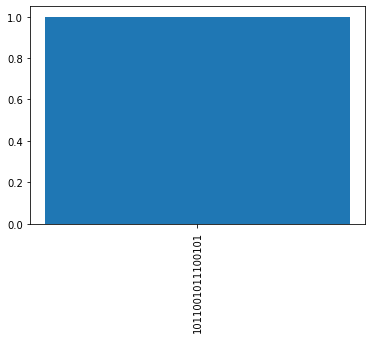

<Figure size 720x720 with 0 Axes>

In [32]:
plt.hist(qubit_results, bins = len(qubit_results))
plt.xticks(rotation='vertical')
plt.figure(figsize=(10,10)) 
plt.show()

In [33]:
for i in range(nr_vehicles):
    section_start = test_nsg[i][0][0]
    section_end = test_nsg[i][-1][-1] + 1
    qubit_section_for_vehicle = qubit_results[0][section_start:section_end]

    print(qubit_section_for_vehicle)
    result_evaluation(qubit_section_for_vehicle, section_start, test_sg[i], test_nsg[i])

101100101
node 0 at time slice 0
node 2 at time slice 1
node 9 at time slice 2
node 9 at time slice 3
node 9 at time slice 4
1100101
node 0 at time slice 0
node 1 at time slice 1
node 6 at time slice 2
node 6 at time slice 3
